### 导入所需要的包和模块

In [41]:
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

### 生成数据集

In [42]:
num_inputs = 2
num_examples = 1000
true_w = [2,-3.4]
true_b = 4.2
features = torch.randn(num_examples,num_inputs,dtype = torch.float32)
labels = true_w[0]*features[:,0]+true_w[1]*features[:,1]+true_b
labels += torch.tensor(np.random.normal(0,0.01,size = labels.size()),
                       dtype = torch.float32)
print(features[:10,:],labels[:10])

tensor([[ 0.3133,  0.1936],
        [ 1.3270,  1.5251],
        [-2.0796,  1.9322],
        [ 1.4623, -1.0369],
        [ 1.4384,  0.3734],
        [-0.2042, -0.6724],
        [ 1.0448,  0.5863],
        [-1.4673,  0.6233],
        [-0.3156, -0.0346],
        [-2.5318,  1.9380]]) tensor([ 4.1814,  1.6700, -6.5456, 10.6347,  5.7989,  6.0897,  4.2960, -0.8565,
         3.6610, -7.4655])


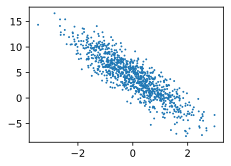

In [43]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);


### 读取数据

In [44]:
def data_iter(batch_size, features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        j = torch.LongTensor(indices[i:min(i + batch_size, num_examples)])
        yield features.index_select(0,j), labels.index_select(0,j)
    

In [45]:
batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X,y)
    break

tensor([[-0.6484,  0.4906],
        [ 0.9900, -0.9912],
        [ 0.3430,  0.4831],
        [-1.0608,  1.6734],
        [-0.1037,  1.3827],
        [ 0.7333, -0.3953],
        [-0.7345, -0.2834],
        [ 0.7340,  0.7331],
        [-0.2551, -1.2274],
        [ 1.2022, -1.0649]]) tensor([ 1.2227,  9.5535,  3.2385, -3.6107, -0.6897,  7.0195,  3.6874,  3.1840,
         7.8648, 10.2327])


### 初始化参数模型

#### 将权重初始化成均值为0 标准差为0.01 的正态随机数 偏差则初始化为0

In [46]:
w = torch.tensor(np.random.normal(0,0.01,(num_inputs,1)),dtype = torch.float32)
b = torch.zeros(1,dtype = torch.float32)

#### 之后的训练模型中 需要对这些参数求梯度来迭代参数的值 因此我们要让他们的 requires_grad = True

In [47]:
w.requires_grad_(requires_grad = True)
b.requires_grad_(requires_grad = True)

tensor([0.], requires_grad=True)

### 定义模型

In [48]:
def linreg(X,w,b):
    return torch.mm(X,w)+b

### 定义损失函数

#### 使用平方损失来定义线性回归的损失函数 在实现中 我们需要把真实值y变成预测值y_hat的形状

In [49]:
def squared_loss(y_hat,y):
    return(y_hat - y.view(y_hat.size()))**2 / 2

### 定义优化算法

#### 以下的sgd函数实现了上一节介绍的小批量随机梯度下降算法 它通过不断迭代模型参数来优化损失函数 这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和 我们将他除以批量大小来得到平均值

In [50]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

### 训练模型

#### 在训练中 我们将多次迭代模型参数 。在每次迭代中 我们根据当前读取的小批量数据样本（特征x 和 特征 y）通过调用反向函数 计算小批量随机梯度 并调用优化算法sgd迭代模型参数由于设置的batch_size是10 每个批量的损失L的形状为（10，1）由于L不是一个标量 所以可以调用.sum()将其求和得到一个标量 再运行l.backward()得到该变量有关参数的梯度 每次更新完参数后要将参数的梯度清零

#### 在一个迭代周期（epoch)中，我们完整遍历一遍data_iter函数 并对训练集中所有样本都使用一次 这里的迭代周期num_epoch和lr学习率都是超参数 分别设为3和0.03 


In [51]:
lr = 0.03
num_epochs = 3
loss = squared_loss

In [53]:
for epoch in range(num_epochs):
    for X,y in data_iter(bach_size,features,labels):
        l = loss(linreg(X,w,b),y).sum()#l必须是标量
        l.backward()
        sgd([w,b],lr,batch_size)
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(linreg(features,w,b),labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.030256
epoch 2, loss 0.000105
epoch 3, loss 0.000050


In [54]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0000],
        [-3.3999]], requires_grad=True)
4.2 
 tensor([4.1993], requires_grad=True)


#### 可以看出，仅使用Tensor和autograd模块就可以很容易地实现一个模型。接下来，本书会在此基础上描述更多深度学习模型，并介绍怎样使用更简洁的代码（见下一节）来实现它们。
